In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import polars as pl
import sys
from python.preproc.time_domain_base import bandpass_filter, standardize_df_columns, normalize_df_columns, bandpass_envelope_downsample
import duckdb
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy.signal import chirp

# Normalize and Standardize Test

In [3]:
df_tmp = pl.DataFrame({"A": np.arange(10), "B": np.concatenate((np.zeros(5), np.ones(5)))})
df_tmp.head()

A,B
i64,f64
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [4]:
df_tmp.pipe(standardize_df_columns, ["A"], ['B'])

A,B
f64,f64
-1.264911,0.0
-0.632456,0.0
0.0,0.0
0.632456,0.0
1.264911,0.0
-1.264911,1.0
-0.632456,1.0
0.0,1.0
0.632456,1.0


In [5]:
df_tmp.pipe(normalize_df_columns, ["A"], by_cols=['B'])

A,B
f64,f64
0.0,0.0
0.25,0.0
0.5,0.0
0.75,0.0
1.0,0.0
0.0,1.0
0.25,1.0
0.5,1.0
0.75,1.0


In [6]:
df_tmp.pipe(normalize_df_columns, ["A"], by_cols=[])

A,B
f64,f64
0.0,0.0
0.111111,0.0
0.222222,0.0
0.333333,0.0
0.444444,0.0
0.555556,1.0
0.666667,1.0
0.777778,1.0
0.888889,1.0


# Bandpass Filter Test

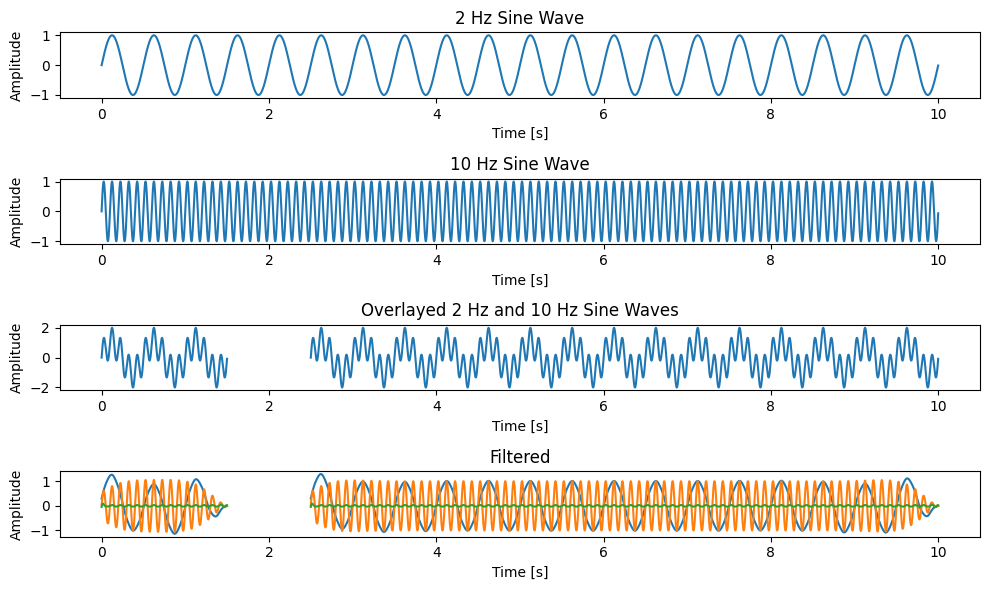

In [3]:
# Set the sample rate and the duration
fs = 1000  # sample rate in Hz
t = np.arange(0, 10, 1/fs, dtype=float)  # time vector over 1 second

# Generate a 2 Hz sine wave
freq1 = 2  # frequency in Hz
sine_wave1 = np.sin(2 * np.pi * freq1 * t)

# Generate a 10 Hz sine wave
freq2 = 10  # frequency in Hz
sine_wave2 = np.sin(2 * np.pi * freq2 * t)

# Overlay the two sine waves
overlayed_wave = sine_wave1 + sine_wave2

overlayed_wave[1500:2500] = np.nan

df_tmp = pl.from_numpy(overlayed_wave)
df_tmp = bandpass_filter(df_tmp, ['column_0'], {'Delta': (2, [0.5, 4], 1000), 'Alpha': (2, [9,11], 1000),
                                                'Beta': (2, [15, 30], 1000)})
filtered_delta = df_tmp.get_column('column_0_Delta').to_numpy()
filtered_alpha = df_tmp.get_column('column_0_Alpha').to_numpy()
filtered_beta = df_tmp.get_column('column_0_Beta').to_numpy()

# Plotting the waves
plt.figure(figsize=(10, 6))

# Plot the first sine wave
plt.subplot(4, 1, 1)
plt.plot(t, sine_wave1)
plt.title('2 Hz Sine Wave')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Plot the second sine wave
plt.subplot(4, 1, 2)
plt.plot(t, sine_wave2)
plt.title('10 Hz Sine Wave')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Plot the overlayed sine wave
plt.subplot(4, 1, 3)
plt.plot(t, overlayed_wave)
plt.title('Overlayed 2 Hz and 10 Hz Sine Waves')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(4, 1, 4)
plt.plot(t, filtered_delta)
plt.title('Filtered')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(4, 1, 4)
plt.plot(t, filtered_alpha)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(4, 1, 4)
plt.plot(t, filtered_beta)
plt.title('Filtered')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


# Bandpass Envelope Downsample Test

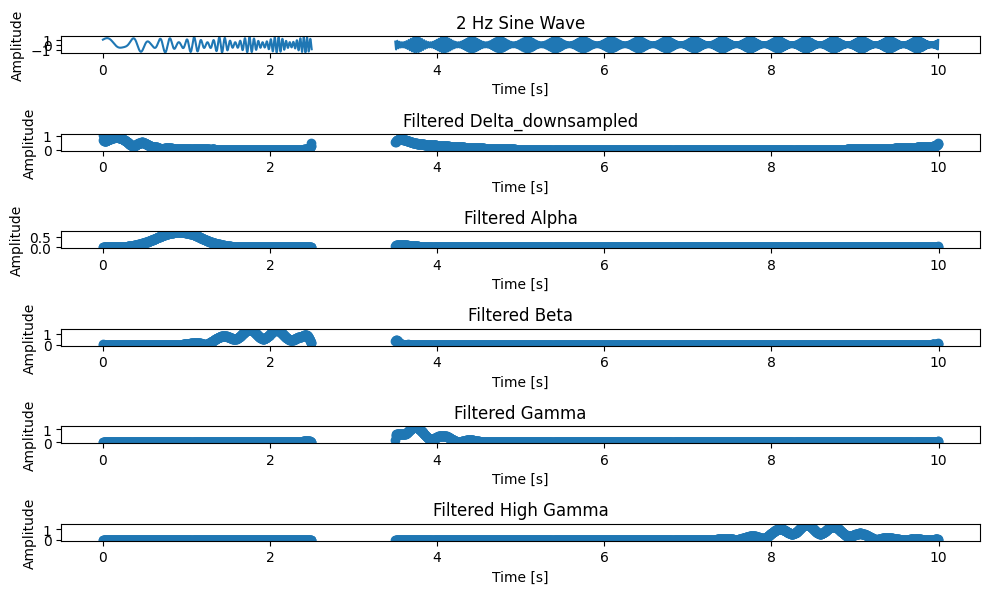

In [19]:
duration = 10.0
fs = 1000.0
samples = int(fs*duration)
t = np.arange(samples) / fs

# We create a chirp of which the frequency increases from 20 Hz to 100 Hz and apply an amplitude modulation.
min_freq = 1.0
max_freq = 100.0
signal = chirp(t, min_freq, t[-1], max_freq)
signal *= (1.0 + 0.5 * np.sin(2.0*np.pi*3.0*t) )

signal[2500:3500] = np.nan

downsample_factor = 4
df_tmp = pl.from_numpy(signal)
df_tmp = bandpass_envelope_downsample(df_tmp, ['column_0'], {'Delta': (2, [0.5, 4], 1000), 'Alpha': (2, [9,11], 1000),
                                                'Beta': (2, [15, 25], 1000), 'Gamma': (2, [30, 40], 1000),
                                                'High_Gamma': (2, [80, 90], 1000)}, downsample_factor)

filtered_delta = df_tmp.get_column('column_0_Delta_downsampled').to_numpy()
filtered_alpha = df_tmp.get_column('column_0_Alpha_downsampled').to_numpy()
filtered_beta = df_tmp.get_column('column_0_Beta_downsampled').to_numpy()
filtered_gamma = df_tmp.get_column('column_0_Gamma_downsampled').to_numpy()
filtered_high_gamma = df_tmp.get_column('column_0_High_Gamma_downsampled').to_numpy()


samples_decimated = int(samples/downsample_factor)
xnew = np.linspace(0, np.size(signal), samples_decimated, endpoint=False)

# Plotting the waves
plt.figure(figsize=(10, 6))

# Plot the first sine wave
plt.subplot(6, 1, 1)
plt.plot(t, signal)
plt.title('2 Hz Sine Wave')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Plot the second sine wave
plt.subplot(6, 1, 2)
plt.scatter(t, filtered_delta)
plt.title('Filtered Delta_downsampled')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Plot the overlayed sine wave
plt.subplot(6, 1, 3)
plt.scatter(t, filtered_alpha)
plt.title('Filtered Alpha')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(6, 1, 4)
plt.scatter(t, filtered_beta)
plt.title('Filtered Beta')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')


plt.subplot(6, 1, 5)
plt.scatter(t, filtered_gamma)
plt.title('Filtered Gamma')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(6, 1, 6)
plt.scatter(t, filtered_high_gamma)
plt.title('Filtered High Gamma')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [20]:
import duckdb

In [22]:
duckdb.read_json('/media/dropbox_hdd/Starr Lab Dropbox/Projects/Sleep/RCS02L/Overnight/Session1650952172805/DeviceNPC700398H/RawDataTD.json')

InvalidInputException: Invalid Input Error: Malformed JSON in file "/media/dropbox_hdd/Starr Lab Dropbox/Projects/Sleep/RCS02L/Overnight/Session1650952172805/DeviceNPC700398H/RawDataTD.json", at byte 2097149 in object 2: unexpected end of data. Try increasing "maximum_object_size".